In [7]:
#Installing necessay imports
#!pip install torch torchvision transformers tqdm matplotlib scikit-learn gradio fuzzywuzzy Pillow

In [1]:
#importing libraries
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from shutil import copyfile
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from PIL import Image
import os
import torch
from fuzzywuzzy import process
import torchvision.transforms as transforms
import torch.nn.functional as F
import gradio as gr


/Users/raynasolanki/Desktop/rayna_solanki/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/raynasolanki/Desktop/rayna_solanki/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/raynasolanki/Desktop/rayna_solanki/.venv/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Custom transformation function
def transform_image(image):
    # The feature extractor handles resizing and normalization
    return feature_extractor(image, return_tensors='pt').pixel_values.squeeze()

# Transformation pipeline
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to three channels
    transforms.Lambda(transform_image)  # Apply the custom transform function
])

# Load the model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2)
model.to(device)

# Hyperparameters
learning_rate = 5e-5
weight_decay = 0.1

# Optimizer and Loss function
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = CrossEntropyLoss()

/Users/raynasolanki/Desktop/Designing_AI/env/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Desired number of images for each class
desired_normal_count = 1000
desired_pneumonia_count = 1000

# List all images in each subfolder
normal_images = os.listdir('chest_xray/train/NORMAL')
pneumonia_images = os.listdir('chest_xray/train/PNEUMONIA')

# Randomly select a subset of images for each class
selected_normal_images = random.sample(normal_images, desired_normal_count)
selected_pneumonia_images = random.sample(pneumonia_images, desired_pneumonia_count)

# Create a new directory to store the selected subset of images
os.makedirs('chest_xray/train_subset/NORMAL', exist_ok=True)
os.makedirs('chest_xray/train_subset/PNEUMONIA', exist_ok=True)

# Move or copy the selected images to the new directories
for image in selected_normal_images:
    copyfile(os.path.join('chest_xray/train/NORMAL', image), os.path.join('chest_xray/train_subset/NORMAL', image))

for image in selected_pneumonia_images:
    copyfile(os.path.join('chest_xray/train/PNEUMONIA', image), os.path.join('chest_xray/train_subset/PNEUMONIA', image))

# Update the root parameter of the ImageFolder class to point to the new directory
train_dataset = datasets.ImageFolder(root='chest_xray/train_subset', transform=transform)
test_dataset = datasets.ImageFolder(root='chest_xray/test', transform=transform)
val_dataset = datasets.ImageFolder(root='chest_xray/val', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

Training Images:


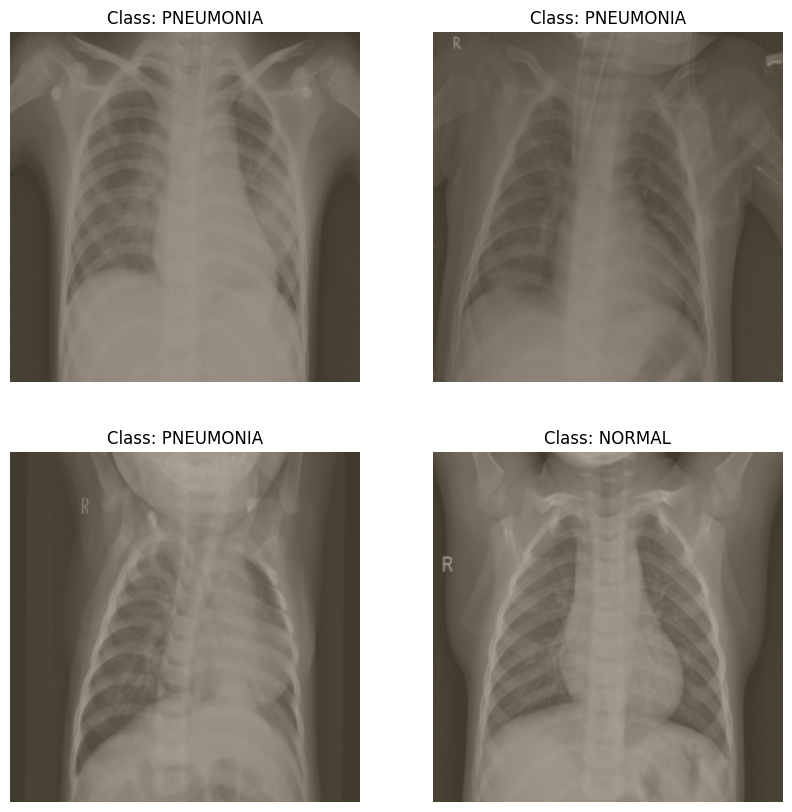

Test Images:


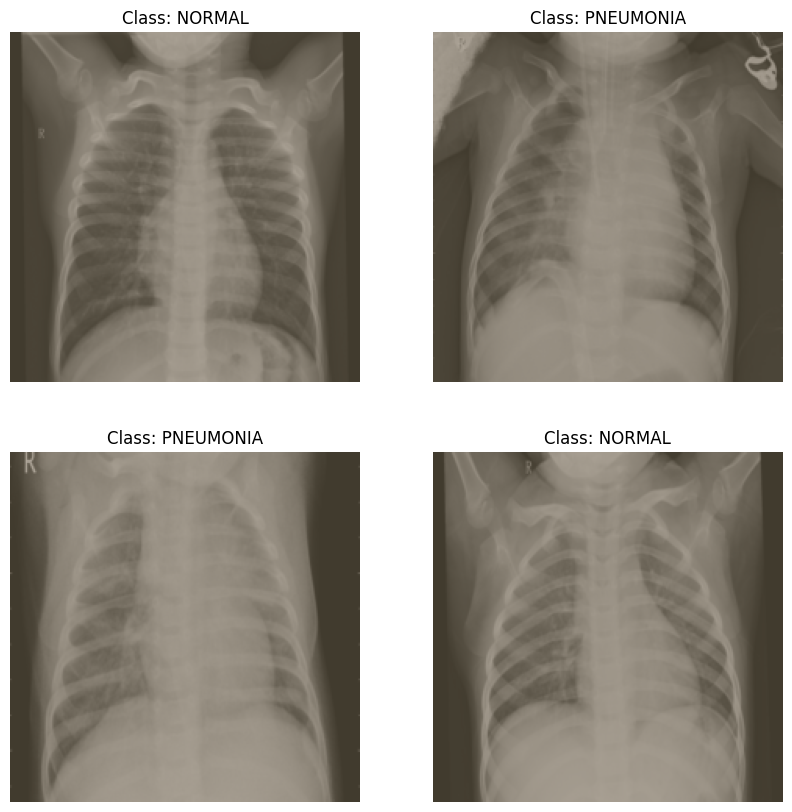

In [20]:
# Function to show images
def show_images(dataloader):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        img = images[i].permute(1, 2, 0)  # Change CxHxW to HxWxC
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        img = img.clamp(0, 1)  # Clamp the values to [0, 1] for valid image display
        plt.imshow(img)
        plt.title(f'Class: {train_dataset.classes[labels[i]]}')
        plt.axis('off')
    plt.show()

# Display some training images
print("Training Images:")
show_images(train_loader)

# Display some test images
print("Test Images:")
show_images(test_loader)

In [16]:
# Training function
def train(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(loader), accuracy, precision, recall, f1

# Validation function
def validate(model, loader, device):
    model.eval()
    total_loss = 0
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(loader), accuracy, precision, recall, f1

In [17]:
#Predicting image function
def predict_image(image_path, model, device, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image).logits
        _, prediction = torch.max(outputs, dim=1)
    return prediction.item()

# Main training loop and chatbot interaction
def main():
    epochs = 3
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        train_loss, train_accuracy, train_precision, train_recall, train_f1 = train(model, train_loader, optimizer, loss_fn, device)
        print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}')
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(model, val_loader, device)
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')

    # Save the trained model
    torch.save(model.state_dict(), 'vit-pneumonia-model2.pth')

if __name__ == '__main__':
    main()

Epoch 1/3


100%|██████████| 297/297 [17:42<00:00,  3.58s/it]


Training Loss: 0.1358, Accuracy: 0.9489, Precision: 0.9486, Recall: 0.9489, F1 Score: 0.9486


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Validation Loss: 0.0752, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch 2/3


100%|██████████| 297/297 [17:41<00:00,  3.57s/it]


Training Loss: 0.0589, Accuracy: 0.9806, Precision: 0.9807, Recall: 0.9806, F1 Score: 0.9806


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Validation Loss: 0.0199, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch 3/3


100%|██████████| 297/297 [23:27<00:00,  4.74s/it]


Training Loss: 0.0254, Accuracy: 0.9937, Precision: 0.9937, Recall: 0.9937, F1 Score: 0.9937


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Validation Loss: 0.0383, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


In [5]:
#Getting all metrics for test set
def evaluate_model(model_path, test_loader, device):
    # Load the pre-trained model
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

# Path to your model
model_path = 'vit-pneumonia-model2.pth'

# Call the evaluation function
print("Evaluating on test set:")
evaluate_model(model_path, test_loader, device)


Evaluating on test set:


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 39/39 [00:56<00:00,  1.44s/it]

Accuracy: 0.8811
Precision: 0.8914
Recall: 0.8811
F1 Score: 0.8765


In [22]:
#Example usage on a "Normal" Chest X-ray from the Internet
#replace image path with any image from the test or from the interent
image_path = "/Users/raynasolanki/Desktop/Designing_AI/0.jpeg"
prediction = predict_image(image_path, model, device, transform)
class_names = ['Normal', 'Pneumonia']
print(f'Predicted class: {class_names[prediction]}')

Predicted class: Normal


In [2]:
# Initialize the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained Vision Transformer model and prepare it for inference
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2)
model.load_state_dict(torch.load('vit-pneumonia-model2.pth', map_location=device))
model.to(device)
model.eval()

# Initialize the Vision Transformer image processor
processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

class PneumoniaChatbot:
    def __init__(self):
        self.context = self.load_context()
        self.synonyms = self.define_synonyms()

    def load_context(self):
        return {
        "introduction": "Pneumonia is an infection caused by bacteria, viruses, or fungi. It leads to inflammation in the air sacs of one or both lungs. These sacs, called alveoli, fill with fluid or pus, making it difficult to breathe.",
        "contagious": "Both viral and bacterial pneumonia is contagious. This means they can spread from person to person through inhalation of airborne droplets from a sneeze or cough. You can also get these types of pneumonia by coming into contact with surfaces or objects that are contaminated with pneumonia-causing bacteria or viruses.",
        "types": "Pneumonia is further classified according to where or how it was acquired: Hospital-acquired pneumonia (HAP) is acquired during a hospital stay and can be more serious due to antibiotic-resistant bacteria. Community-acquired pneumonia (CAP) refers to pneumonia acquired outside of medical settings. Ventilator-associated pneumonia (VAP) occurs in people using ventilators. Aspiration pneumonia happens when bacteria from food, drink, or saliva enter the lungs.",
        "symptoms": "Pneumonia symptoms can be mild to life-threatening. They can include coughing, fever, sweating or chills, shortness of breath, chest pain, fatigue, loss of appetite, nausea or vomiting. Infants may show symptoms like vomiting or lack of energy, while older adults may experience confusion or a lower-than-normal body temperature.",
        "causes": "Pneumonia happens when germs get into your lungs and cause an infection. The immune system’s reaction results in inflammation of the lung’s air sacs, filling them with pus and liquids. Several types of infectious agents can cause pneumonia, including bacteria like Streptococcus pneumoniae, viruses like influenza, and fungi like Pneumocystis jirovecii.",
        "diagnosis": "Your doctor will start by taking your medical history and performing a physical exam, including listening to your lungs with a stethoscope. Depending on the severity of your symptoms, tests such as chest X-ray, blood culture, sputum culture, pulse oximetry, CT scan, or bronchoscopy may be ordered to confirm the diagnosis and identify the cause of the infection.",
        "treatment": "Your treatment will depend on the type of pneumonia you have, how severe it is, and your general health. Prescription medications such as antibiotics, antivirals, or antifungals may be prescribed. Over-the-counter medications like pain relievers and cough medicine may also be recommended. Home remedies such as rest, fluids, and warm compresses can help ease symptoms. Severe cases may require hospitalization for intravenous antibiotics, respiratory therapy, or oxygen therapy.",
        "complications": "Pneumonia may cause complications, especially in people with weakened immune systems or chronic conditions. Complications may include worsening of chronic conditions like congestive heart failure, bacteremia leading to septic shock, lung abscesses, impaired breathing requiring ventilation, acute respiratory distress syndrome, pleural effusion, and damage to organs like the kidneys, heart, and liver. In severe cases, pneumonia can be fatal.",
        "prevention": "In many cases, pneumonia can be prevented. Vaccination is the first line of defense, including vaccines against pneumococcal bacteria, influenza, and Haemophilus influenzae type b. Other preventive measures include hand hygiene, cough etiquette, maintaining a healthy lifestyle to strengthen the immune system, avoiding known risk factors such as smoking and exposure to lung irritants, and getting prompt medical attention for respiratory infections.",
        "cure": "A variety of infectious agents cause pneumonia. With proper recognition and treatment, many cases of pneumonia can be cleared without complications. Bacterial pneumonia is treated with antibiotics, viral pneumonia often resolves on its own but may require antiviral medication, and fungal pneumonia is treated with antifungal medication. However, stopping antibiotics early can lead to incomplete clearance of the infection and antibiotic resistance.",
        "pregnancy": "Pneumonia that occurs during pregnancy is called maternal pneumonia. Pregnant individuals are more at risk due to the natural suppression of the immune system. Symptoms of pneumonia don’t differ by trimester, but complications can lead to premature birth and low birth weight. Prompt medical attention is crucial if symptoms arise during pregnancy.",
        "children": "Pneumonia can be a rather common childhood condition, affecting approximately 1 in 71 children worldwide each year. Causes vary by age, with respiratory viruses, Streptococcus pneumoniae, and Haemophilus influenzae being common in children under 5 years old. Mycoplasma pneumoniae is frequently observed in children between the ages of 5 and 13, often causing walking pneumonia. Prompt medical attention is necessary if children show symptoms like trouble breathing, lack of energy, or changes in appetite."
        
        }
    
    pass

    def define_synonyms(self):
        # Define synonyms for each key in your context dictionary
        return{
        "introduction": [
            "what is pneumonia", "define pneumonia", "pneumonia definition", "pneumonia overview",
            "pneumonia basics", "tell me about pneumonia", "overview of pneumonia",
            "pneumonia information", "pneumonia intro", "what do you know about pneumonia",
            "explain pneumonia", "pneumonia background", "pneumonia summary",
            "introduction to pneumonia", "pneumonia guide", "understanding pneumonia",
            "pneumonia for beginners", "start with pneumonia", "pneumonia explained",
            "what exactly is pneumonia"
        ],
        "contagious": [
            "is it contagious", "can it spread", "contagiousness of pneumonia", "how does pneumonia spread",
            "pneumonia transmission", "spreading pneumonia", "catching pneumonia", "is pneumonia infectious",
            "pneumonia risk to others", "can I give someone pneumonia", "pneumonia spreading",
            "contagion of pneumonia", "how is pneumonia transmitted", "can you catch pneumonia from someone",
            "risk of spreading pneumonia", "pneumonia infectivity", "transmissible pneumonia",
            "communicability of pneumonia", "is pneumonia transferable", "spreading of pneumonia"
        ],
        "types": [
            "kinds of pneumonia", "pneumonia categories", "what types are there", "different pneumonia types",
            "pneumonia classification", "types of pneumonia", "pneumonia variants", "pneumonia strains",
            "forms of pneumonia", "varieties of pneumonia", "pneumonia kinds", "pneumonia diversities",
            "pneumonia distinctions", "how many types of pneumonia", "main types of pneumonia",
            "pneumonia taxonomy", "categories of pneumonia", "groupings of pneumonia", "pneumonia branches",
            "classification of pneumonia"
        ],
        "symptoms": [
            "signs of pneumonia", "pneumonia symptoms", "how do I know if I have pneumonia",
            "indications of pneumonia", "pneumonia signs", "symptoms of pneumonia", "pneumonia manifestations",
            "what are the symptoms of pneumonia", "identifying pneumonia", "pneumonia warning signs",
            "signals of pneumonia", "how to tell pneumonia", "early symptoms of pneumonia",
            "common pneumonia symptoms", "pneumonia indicators", "detecting pneumonia symptoms",
            "are there symptoms for pneumonia", "what does pneumonia feel like", "pneumonia presentation",
            "pneumonia criteria"
        ],
        "causes": [
            "what causes pneumonia", "pneumonia origins", "how do you get pneumonia", "pneumonia causation",
            "root causes of pneumonia", "pneumonia etiology", "causes of pneumonia", "how pneumonia starts",
            "what leads to pneumonia", "pneumonia sources", "pneumonia triggers", "initiation of pneumonia",
            "pneumonia cause", "how is pneumonia caused", "factors of pneumonia", "pneumonia risk factors",
            "what results in pneumonia", "why does pneumonia happen", "pneumonia contributors",
            "origin of pneumonia"
        ],
        "diagnosis": [
            "how to diagnose pneumonia", "pneumonia diagnosis", "detecting pneumonia", "pneumonia tests",
            "identifying pneumonia", "how do doctors test for pneumonia", "pneumonia detection",
            "diagnosing pneumonia", "pneumonia examination", "pneumonia assessment", "tests for pneumonia",
            "pneumonia checkup", "how is pneumonia diagnosed", "pneumonia screening", "pneumonia confirmation",
            "methods to diagnose pneumonia", "diagnosis process of pneumonia", "pneumonia identification",
            "pneumonia diagnostics", "examining for pneumonia"
        ],
        "treatment": [
        "how to treat pneumonia", "pneumonia remedies", "curing pneumonia", "treatment for pneumonia",
        "pneumonia cure methods", "how to get rid of pneumonia", "medication for pneumonia",
        "pneumonia recovery process", "best way to treat pneumonia", "pneumonia treatment options",
        "healing pneumonia", "ways to cure pneumonia", "what do doctors prescribe for pneumonia",
        "pneumonia healing", "getting better from pneumonia", "can pneumonia be treated at home",
        "hospital treatment for pneumonia", "how long to treat pneumonia", "pneumonia care",
        "treatment duration for pneumonia"
        ],

        "complications": [
            "pneumonia risks", "can pneumonia be fatal", "dangers of pneumonia", "pneumonia complications",
            "is pneumonia deadly", "worst case of pneumonia", "pneumonia severity", "what can pneumonia lead to",
            "pneumonia consequences", "long term effects of pneumonia", "can pneumonia damage the lungs",
            "pneumonia health impacts", "aftereffects of pneumonia", "complications from pneumonia",
            "serious pneumonia", "pneumonia and hospitalization", "is pneumonia serious", "can pneumonia cause death",
            "pneumonia aftermath", "surviving pneumonia"
        ],

        "prevention": [
            "how to prevent pneumonia", "avoiding pneumonia", "pneumonia prevention measures",
            "ways to prevent pneumonia", "pneumonia vaccines", "pneumonia prophylaxis", "stopping pneumonia before it starts",
            "pneumonia avoidance tactics", "immunization for pneumonia", "keeping pneumonia away",
            "pneumonia prevention tips", "how to not get pneumonia", "reducing pneumonia risk",
            "can pneumonia be prevented", "shielding against pneumonia", "pneumonia prevention strategies",
            "preventing pneumonia in children and adults", "pneumonia risk reduction", "pneumonia guard",
            "avoid pneumonia infection"
        ],

        "cure": [
            "is there a cure for pneumonia", "pneumonia healing", "complete recovery from pneumonia",
            "can you fully recover from pneumonia", "pneumonia resolution", "pneumonia eradication",
            "getting over pneumonia", "can pneumonia go away", "pneumonia cure time", "overcoming pneumonia",
            "beat pneumonia", "pneumonia recovery", "pneumonia treatment success", "how to clear pneumonia",
            "pneumonia remission", "permanent cure for pneumonia", "is pneumonia curable", "recovery path for pneumonia",
            "can I die from pneumonia", "how do I get better from pneumonia","can i die","death"
        ],

        "pregnancy": [
            "pneumonia when pregnant", "pneumonia and pregnancy", "dealing with pneumonia during pregnancy",
            "pregnancy pneumonia risks", "pneumonia effect on pregnancy", "can pneumonia harm my baby",
            "treating pneumonia in pregnancy", "pneumonia in expectant mothers", "pregnancy and battling pneumonia",
            "is pneumonia dangerous for pregnant women", "pneumonia treatment while pregnant",
            "pregnant with pneumonia", "managing pneumonia in pregnancy", "pneumonia during pregnancy",
            "pregnancy complications with pneumonia", "getting pneumonia while pregnant", "pneumonia impact on pregnancy",
            "pneumonia care in pregnancy", "preventing pneumonia in pregnancy", "signs of pneumonia in pregnancy"
        ],

        "children": [
            "pneumonia in children", "pneumonia signs in kids", "childhood pneumonia", "treating pneumonia in children",
            "can kids get pneumonia", "pneumonia recovery for children", "young children and pneumonia",
            "pneumonia treatment for kids", "pneumonia vaccine for children", "how to prevent pneumonia in children",
            "symptoms of pneumonia in kids", "dealing with pneumonia in kids", "is pneumonia common in children",
            "children's pneumonia care", "pneumonia risk in children", "how serious is pneumonia in children",
            "pneumonia in toddlers", "infant pneumonia signs", "protecting children from pneumonia",
            "pneumonia healing in children"
        ],
}

    def answer_question(self, question):
        # Convert the question to lowercase to improve match accuracy
        question = question.lower()
        
        # Try to find the best matching synonym category for the question
        best_category, best_score = None, 0
        for category, synonyms in self.synonyms.items():
            for synonym in synonyms:
                score = process.extractOne(question, [synonym])[1]  # Get the match score
                if score > best_score:
                    best_category, best_score = category, score

        # If a matching category is found with a high enough score, return the related answer
        if best_category and best_score >= 70:
            return f"{self.context[best_category]}\n\nDo you have any other questions about pneumonia?"
        else:
            return "I'm not sure how to answer that. Can you please ask in a different way? Feel free to ask anything about pneumonia, its types, symptoms, causes, diagnosis, treatment, complications, prevention, and more!"
        
# Function to predict the image
def predict_image(uploaded_image):
    if uploaded_image is None:
        return "No image uploaded", "Please upload an image."

    # Convert the uploaded image to the format expected by the model
    image = uploaded_image.convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs.to(device)

    # Perform the prediction
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        prediction = probs.argmax().item()
        prob = probs[0][prediction].item()

    # Generate the appropriate response
    advice = "Detected pneumonia. Feel free to ask questions about pneumonia." if prediction == 1 else "No pneumonia detected."
    return {0: f'Normal ({prob:.2%})', 1: f'Pneumonia ({prob:.2%})'}[prediction], advice
pass

# Create a Gradio Interface
def chat_with_bot(user_input):
    chatbot = PneumoniaChatbot()
    return chatbot.answer_question(user_input)

def create_gradio_interface():
    # Create a Gradio Interface for Pneumonia Detection
    image_interface = gr.Interface(
        fn=predict_image,
        inputs=gr.Image(type="pil", label="Upload your Chest X-ray Image"),
        outputs=[
            gr.Label(label="Classification Result"),
            gr.Textbox(label="Advice")
        ],
        title="Detecting Pneumonia",
        description="Upload a chest X-ray image to automatically detect signs of pneumonia.",
        live=True
    )

    # Create Gradio Interface for the chatbot
    chatbot_interface = gr.Interface(
        fn=chat_with_bot,  # Function that the interface will use
        inputs=gr.Textbox(lines=5, placeholder="Type your question here..."),  # Textbox for user to type their question
        outputs=gr.Textbox(placeholder="The answer will appear here..."),  # Textbox where the chatbot's answer will appear
        title="Pneumonia Chatbot",
        description="Ask any questions about pneumonia and get information."
    )

    # Combine both interfaces into tabs
    combined_interface = gr.TabbedInterface(
        [image_interface, chatbot_interface],
        ["Detecting Pneumonia", "Pneumonia Chatbot"],
        title="Designing AI Project - by Rayna Solanki"
    )

    return combined_interface

if __name__ == '__main__':
    # Create the Gradio app interface
    app = create_gradio_interface()
    
    # Launch the Gradio app
    app.launch(share=True)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/raynasolanki/Desktop/rayna_solanki/.venv/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://190bd4b6a97de33c11.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
